In [2]:
%matplotlib notebook
DEFAULT_FIGSIZE = (12, 8)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint
from antlia import trial2

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

In [3]:
with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

bicycle_record_files = [
    '2018-04-23_12-30-38.csv',
    '2018-04-23_13-13-36.csv',
    '2018-04-23_14-22-58.csv',
    '2018-04-23_15-27-48.csv',
    '2018-04-23_16-32-27.csv',
    '2018-04-23_17-14-00.csv',
    '2018-04-25_09-27-24.csv',
    '2018-04-25_10-20-28.csv',
    '2018-04-25_11-34-04.csv',
    '2018-04-25_12-41-48.csv',
    '2018-04-25_14-14-57.csv',
    '2018-04-25_14-49-39.csv',
    '2018-04-25_16-15-57.csv',
    '2018-04-25_17-23-04.csv',
    '2018-04-26_11-19-31.csv',
    '2018-04-26_14-50-53.csv',
    '2018-04-27_14-59-52.csv'
]

lidar_record_files = [
    '2018-04-23-12-17-37_0.pkl.gz',
    '2018-04-23-13-01-00_0.pkl.gz',
    '2018-04-23-14-10-33_0.pkl.gz',
    '2018-04-23-15-15-14_0.pkl.gz',
    '2018-04-23-16-19-35_0.pkl.gz',
    '2018-04-23-17-01-24_0.pkl.gz',
    '2018-04-25-09-15-00_0.pkl.gz',
    '2018-04-25-10-07-31_0.pkl.gz',
    '2018-04-25-11-21-29_0.pkl.gz',
    '2018-04-25-12-29-06_0.pkl.gz',
    '2018-04-25-14-02-15_0.pkl.gz',
    '2018-04-25-14-36-55_0.pkl.gz',
    '2018-04-25-16-03-24_0.pkl.gz',
    '2018-04-25-17-10-07_0.pkl.gz',
    '2018-04-26-11-07-38_0.pkl.gz',
    '2018-04-26-14-38-03_0.pkl.gz',
    '2018-04-27-14-47-07_0.pkl.gz',
    '2018-04-27-15-39-56_0.pkl.gz'
]

records = []
data_dir = '../../data/comfort'
i = 0
for file1, file2 in zip(bicycle_record_files, lidar_record_files):
    r1 = load_file(os.path.join(data_dir, file1), bicycle_calibration['convbike'])
    r2 = load_converted_record(os.path.join(data_dir, file2))
    r = Record(r2, r1)
    records.append(r)
    print('loaded record from files: {}, {}'.format(file1, file2))
    i += 1
    #if i >= 8:
    if i >= 0:
        break

loaded record from files: 2018-04-23_12-30-38.csv, 2018-04-23-12-17-37_0.pkl.gz


In [4]:
# notes on missing syncs and repeated trials
missing_sync = [
   [680], None, None, None, None,
   None, None, None, None, None,
   None, None, None, None, None,
   None, None
]

trial_mask = [
   None, None, 0, None, None,
   0, None, None, 9, None,
   None, 11, 8, 9, None,
   None, None
]

#assert len(missing_sync) == len(records)

for i, (r, ms, tm) in enumerate(zip(records, missing_sync, trial_mask)):
    print('calculating trials for cyclist', i)
    
    try:
        r.sync()
        r._calculate_trials2(missing_sync=ms, trial_mask=tm)
    except (AssertionError, ValueError) as e:
        print('unable to calculate trials for cyclist', i)
        print(e)

calculating trials for cyclist 0


<IPython.core.display.Javascript object>


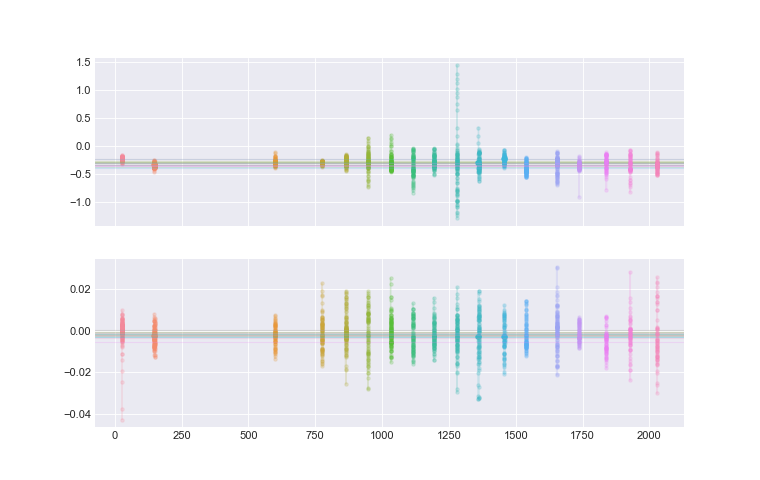

[-0.223 -0.345 -0.285 -0.297 -0.284 -0.273 -0.301 -0.371 -0.281 -0.332
 -0.304 -0.235 -0.393 -0.344 -0.348 -0.303 -0.348 -0.343]
[-0.001 -0.003 -0.002 -0.002  0.    -0.001 -0.001 -0.002 -0.002 -0.002
 -0.003 -0.003 -0.002  0.    -0.001 -0.006 -0.002 -0.004]


In [13]:
# calculate gyroscope, accelerometer offset during sync
plt.close('all')

index = records[0].bicycle.sync.astype(bool)
clumps = np.ma.extras._ezclump(index)

husl_color = sns.husl_palette(len(clumps), l=0.7)
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(9.5, 6))
acc = []
gyro = []
for i, c in enumerate(clumps):
    time = records[0].bicycle['time'][c]
    x = records[0].bicycle['accelerometer x'][c]
    z = records[0].bicycle['gyroscope z'][c]
    
    ax[0].plot(time, x,
               marker='.',
               color=husl_color[i], alpha=0.2)
    acc.append(x.mean())
    ax[0].axhline(x.mean(),
                  linewidth=1,
                  color=husl_color[i], alpha=0.2)
    ax[0].plot(time[[0, -1]],
               2*[x.mean()],
               linewidth=5,
               color=husl_color[i])
    
    ax[1].plot(time, z,
               marker='.',
               color=husl_color[i], alpha=0.2)
    gyro.append(z.mean())
    ax[1].axhline(z.mean(),
                  linewidth=1,
                  color=husl_color[i], alpha=0.2)
    ax[1].plot(time[[0, -1]],
               2*[z.mean()],
               linewidth=5,
               color=husl_color[i])
plt.show()
print(np.round(acc, 3))
print(np.round(gyro, 3))

In [ ]:
from antlia import kalman

# generate Kalman matrices
f, h, F, H = kalman.generate_fhFH(
    constant_velocity=True,
    wheelbase=0.6)

In [76]:

evt = records[0].trials[4].event
trjx, trjy = evt.trajectory(mode='butter')

T = 1/125 # bicycle sample rate
z = kalman.generate_measurement(evt)
x0 = np.array([
    trjx[0:20].max() + 0.5,
    trjy[0:100].mean(),
    np.pi,
    np.abs(np.diff(trjx[:100]).mean())*20,
    0,
    0
])

P0 = np.diag([
    0.1,
    0.1,
    0.01,
    0.2,
    0.1,
    0.2
])

if x0[0] < 20:
    x0[0] = 20
    P0[0, 0] *= 10
if x0[1] < 2.5 or x0[1] > 3.5:
    x0[1] = 3
    P0[1, 1] *= 10
if x0[3] < 1:
    x0[3] = 5
    P0[3, 3] *= 10
print('x0:', x0)

q0 = 1
q1 = 0.01
Q = 1*np.diag([
    q0*T**3/3, # [m] x-position
    q0*T**3/3, # [m] y-position
    q1*T**2/2, # [rad/s] yaw angle
    q0*T**2/2, # [m/s] velocity 
    q1*T, # [rad/s] yaw rate
    q0*T, # [m/s^2] acceleration
])
R = 0.01*np.diag([
    0.01, # x
    0.01, # y
    z[:100, 2].var(),
    z[:100, 3].var(),
])

result = kalman.Kalman(F, H, Q, R, f, h).estimate(
    x0, P0, z, [1, 1, 0, 0], progress=True)

x0: [ 26.61684829   2.94677234   3.14159265   5.59589113   0.           0.        ]
[=================================================================================================== ] 99.9%

<IPython.core.display.Javascript object>


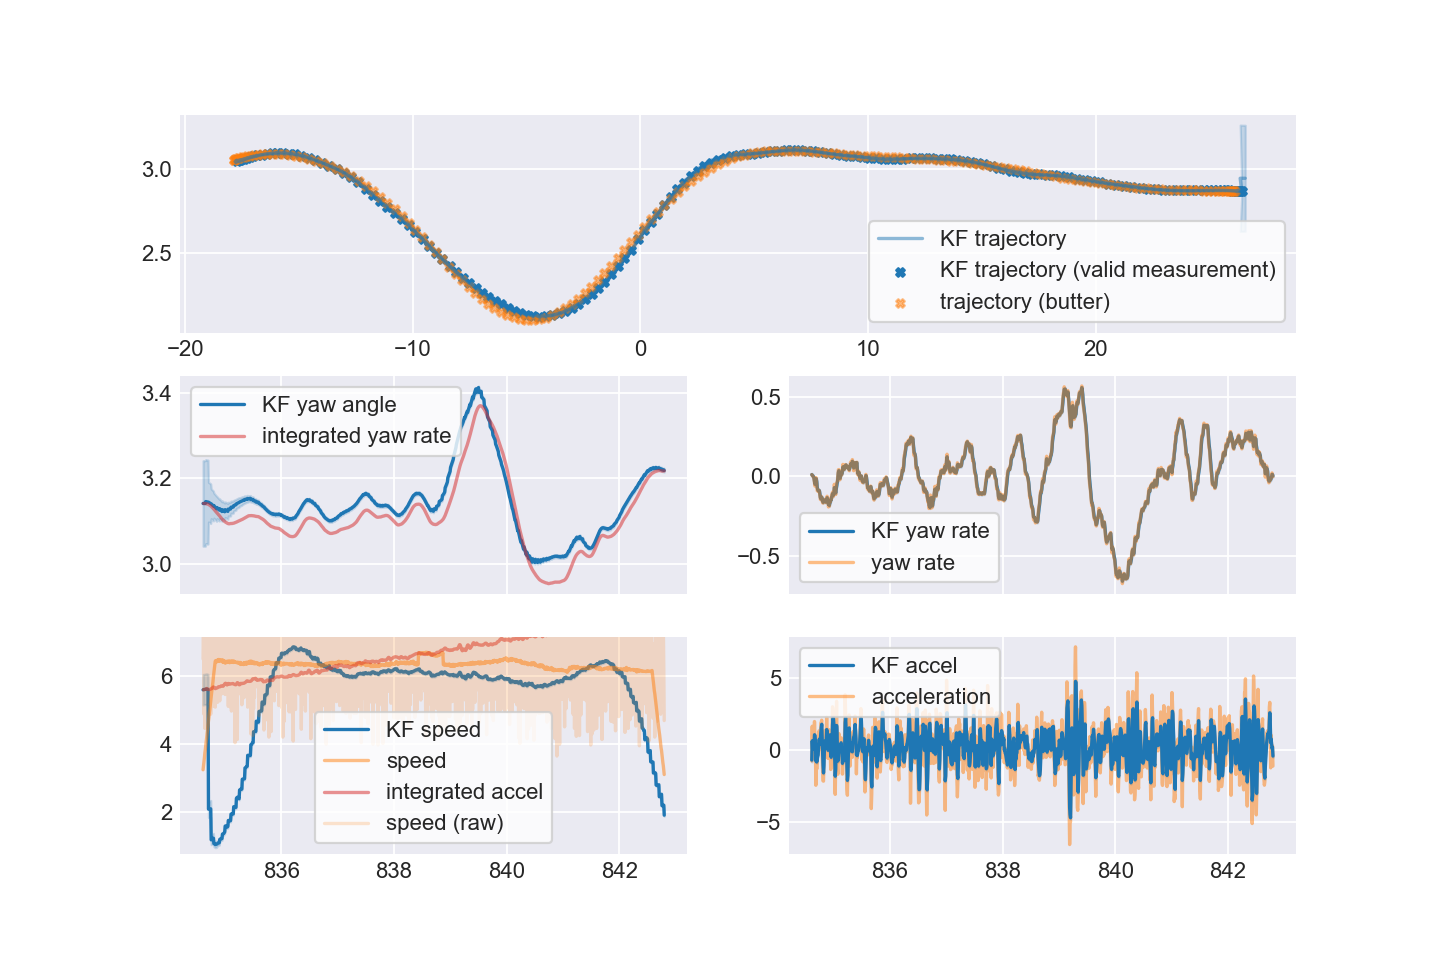

In [77]:
plt.close('all')
fig, ax = kalman.plot_kalman_result(result, evt, figsize=(9, 6))
plt.show()

<IPython.core.display.Javascript object>


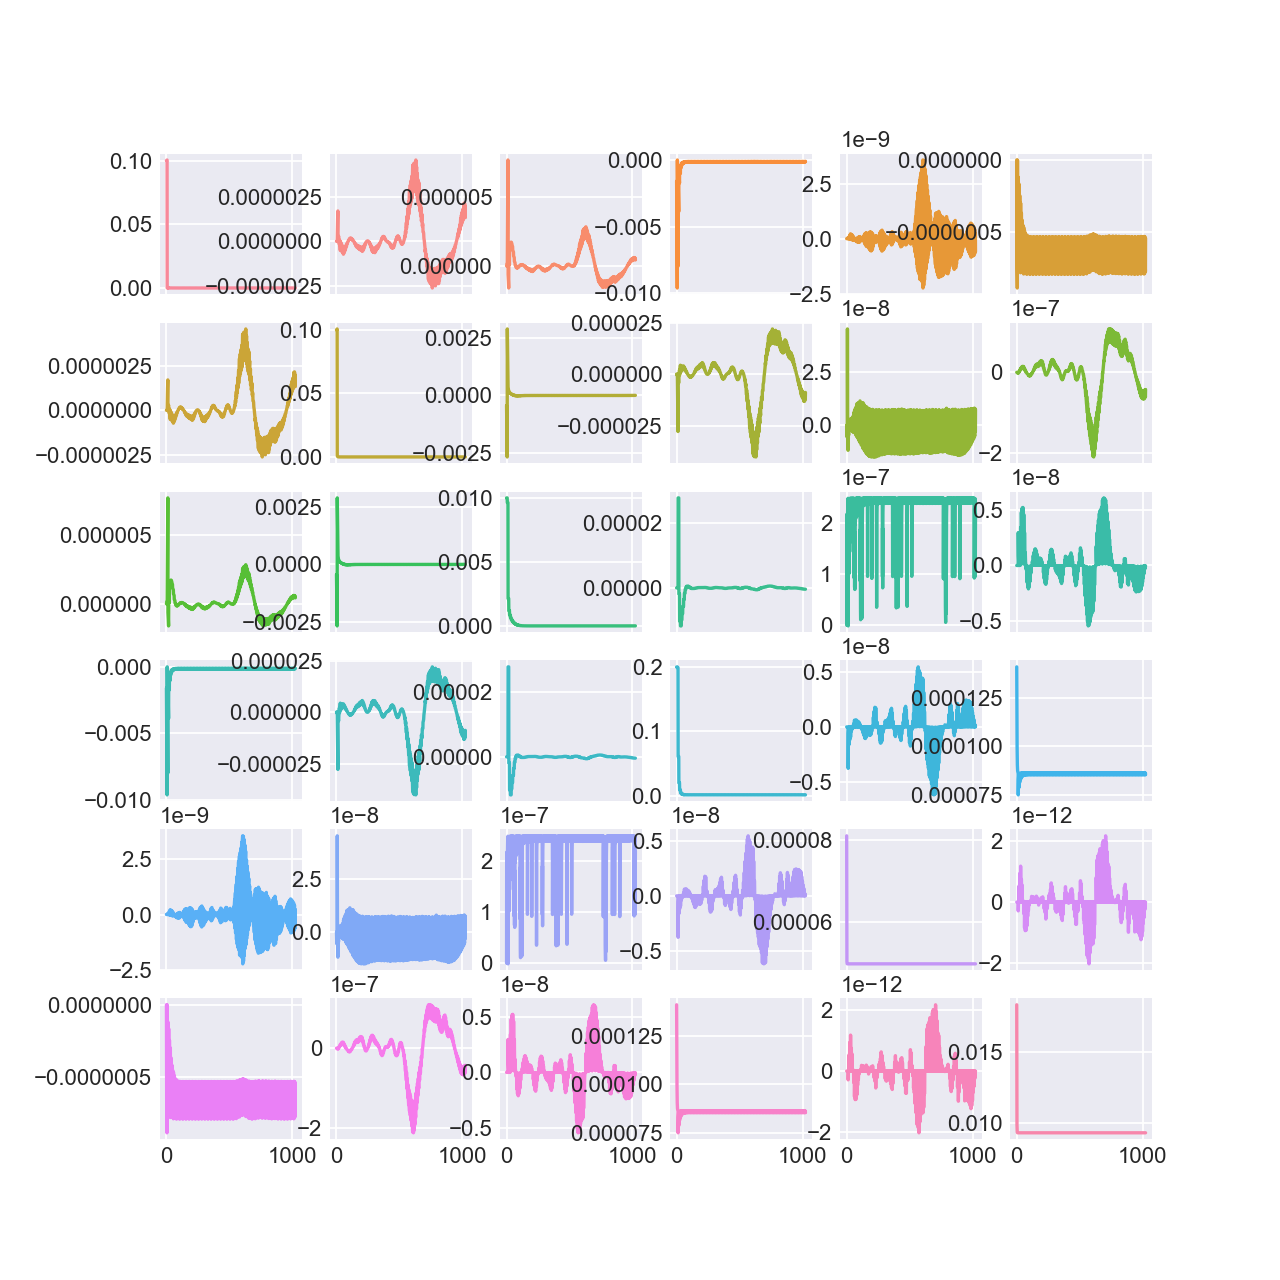

In [74]:
plt.close('all')
fig, ax = kalman.plot_kalman_result_matrix(
    result.error_covariance,
    figsize=(8, 8))
plt.show()